# Descrição do problema

No âmbito da unidade curricular de Ciência de Dados, foi proposto o desenvolvimento de um modelo de machine learning utilizando o dataset "New York City Taxi Trips". O objetivo é construir um modelo capaz de prever o preço das viagens de táxi com base em diversas variáveis disponíveis, como distância da viagem, horário do dia, número de passageiros e possíveis condições de tráfego.

# Objetivo
O principal objetivo deste projeto é desenvolver um modelo que consiga estimar o valor das tarifas de táxi em Nova York. A tarefa será abordada sob duas perspectivas:

1. Regressão: Criar um modelo que consiga prever com precisão o valor exato da tarifa para uma determinada viagem.
2. Classificação: Reformular o problema para classificar as viagens em faixas de preços predefinidas:

    - Classe 1: Viagens curtas e de baixo custo (`< $10`)

    - Classe 2: Viagens de média distância e preço moderado (`$10 - $30`)

    - Classe 3: Viagens longas com tarifas mais elevadas (`$30 - $60`)

    - Classe 4: Tarifas premium (`> $60`)

# Descrição dos Dados

O dataset **New York City Yellow Taxi Trip Records** contém informações detalhadas sobre viagens de táxi na cidade de Nova York, incluindo dados sobre tempo, distância, localizações de embarque e desembarque, além de informações de pagamento.

O dataset inclui as seguintes colunas:

- **VendorID**: Código que identifica o provedor do sistema de processamento eletrônico de pagamentos (TPEP).
  - 1 = Creative Mobile Technologies, LLC
  - 2 = VeriFone Inc.

- **tpep_pickup_datetime**: Data e hora em que o taxímetro foi ativado.
- **tpep_dropoff_datetime**: Data e hora em que o taxímetro foi desativado.
- **Passenger_count**: Número de passageiros no veículo (valor inserido pelo motorista).
- **Trip_distance**: Distância percorrida na viagem (em milhas) reportada pelo taxímetro.
- **PULocationID**: Código da zona TLC onde o taxímetro foi ativado (embarque).
- **DOLocationID**: Código da zona TLC onde o taxímetro foi desativado (desembarque).
- **RateCodeID**: Código da tarifa aplicada ao final da viagem.
  - 1 = Tarifa padrão
  - 2 = JFK
  - 3 = Newark
  - 4 = Nassau ou Westchester
  - 5 = Tarifa negociada
  - 6 = Viagem em grupo

- **Store_and_fwd_flag**: Indica se o registro da viagem foi armazenado antes de ser enviado ao provedor, devido à falta de conexão do veículo com o servidor.
  - Y = Viagem armazenada antes do envio
  - N = Viagem enviada em tempo real

- **Payment_type**: Código que indica a forma de pagamento utilizada pelo passageiro.
  - 1 = Cartão de crédito
  - 2 = Dinheiro
  - 3 = Sem cobrança
  - 4 = Disputa
  - 5 = Desconhecido
  - 6 = Viagem cancelada

- **Fare_amount**: Valor da tarifa baseado no tempo e na distância percorrida.
- **Extra**: Cobranças adicionais, como sobretaxas noturnas ou de horário de pico.
- **MTA_tax**: Taxa de `$0,50` do MTA aplicada automaticamente com base na tarifa do taxímetro.
- **Improvement_surcharge**: Taxa de melhoria de `$0,30` aplicada desde 2015.
- **Tip_amount**: Valor da gorjeta (preenchido automaticamente para pagamentos com cartão; gorjetas em dinheiro não são registradas).
- **Tolls_amount**: Valor total de pedágios pagos durante a viagem.
- **Total_amount**: Valor total cobrado do passageiro (não inclui gorjetas pagas em dinheiro).


In [34]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer




# Data Analysis

A análise de dados será realizada com a abordagem ELT (Extract, Load, Transform). Inicialmente, os dados serão extraídos do KaggleHub e uma amostra aleatória será utilizada para trabalhar com uma fração representativa do conjunto completo. Em seguida, os dados extraídos serão carregados em estruturas como DataFrames Pandas ou arrays NumPy, facilitando a manipulação e análise. Por fim, na fase de transformação, os dados serão limpos, normalizados e preparados para gerar métricas e insights. A amostragem aleatória permite reduzir a complexidade, permitindo uma análise eficiente sem processar todos os dados de uma vez.

In [19]:
class KagglehubDatabaseLoader:
    """
    A class to download and manage datasets from KaggleHub.

    This class automates the process of downloading a dataset from KaggleHub
    and provides a method to retrieve the local file path.

    Attributes:
        _dataset (str): The name of the dataset to be downloaded.
        _path (str or None): The local directory path where the dataset is saved.
    """

    def __init__(self, dataset: str):
        """
        Initializes the KagglehubDatabaseLoader class.

        Args:
            dataset (str): The name of the dataset to be downloaded.
        """
        self._dataset = dataset
        self._path = None

        self._download_dataset()


    def _download_dataset(self) -> None:
        """
        Downloads the specified dataset from KaggleHub.

        This method attempts to download the dataset and assigns the local
        file path to the `_path` attribute. If an error occurs during the
        download, an exception is caught and printed.
        """
        try:
            self._path = kagglehub.dataset_download(self._dataset)
            print("Dataset downloaded Successfully ")
            print("Dataset saved on: ", self._path)
        except Exception as e:
            print("Error downloading dataset:", e)


    def get_path(self) -> str | None:
        """
        Returns the local directory path of the downloaded dataset.

        Returns:
            str or None: The file path of the dataset if the download was
                        successful, otherwise None.
        """
        return self._path


class KagglehubSQLiteLoader(KagglehubDatabaseLoader):
    """
    A subclass of KagglehubDatabaseLoader to interact with an SQLite dataset.

    This class adds methods to retrieve information about tables, numpy arrays and dataframes.
    the SQLite dataset is downloaded from KaggleHub.

    Attributes:
        _dataset (str): The name of the dataset to be downloaded from KaggleHub.
        _path (str or None): The local directory path where the dataset is saved.
        _file_path (str or None): The complete path to the specific SQLite file within the dataset.
        _conn: The SQLite connection object used to interact with the database.
        _cursor: The cursor object for executing SQL queries on the database.
    """

    def __init__(self, dataset: str, file: str):
        """
        Initializes the KagglehubSQLLoader class by calling the superclass constructor
        to download the dataset and setting up the SQLite connection.

        Args:
            dataset (str): The dataset name to be downloaded.
            file (str): The name of the SQLite file in the downloaded dataset to be opened.
        """
        super().__init__(dataset)
        self._file_path = self._path + file
        self._conn = sql.connect(self._file_path)
        self._cursor = self._conn.cursor()


    def get_table_names(self) -> list | None:
        """
        Retrieves all table names from the SQLite database.

        Returns:
            list: A list of table names if successful, None if an error occurs.
        """
        try:
            table_name_query = "SELECT name FROM sqlite_master WHERE type='table';"
            return self._cursor.execute(table_name_query).fetchall()
        except Exception as e:
            print("Error getting table names:", e)


    def get_column_names(self, table: str) -> list | None:
        """
        Retrieves the column names for a given table in the SQLite database.

        Args:
            table (str): The name of the table for which to get column names.

        Returns:
            list: A list of column names if successful, None if an error occurs.
        """
        try:
            self._cursor.execute(f"PRAGMA table_info({table});")
            columns = [col[1] for col in self._cursor.fetchall()]
            return columns
        except Exception as e:
            print("Error getting column names:", e)


    def get_table_row_count(self, table: str) -> int | None:
        """
        Retrieves the row count for a given table.

        Args:
            table (str): The name of the table for which to get the row count.

        Returns:
            int: The number of rows in the table if successful, None if an error occurs.
        """
        try:
            self._cursor.execute(f"SELECT COUNT(*) FROM {table};")
            return self._cursor.fetchone()[0]
        except Exception as e:
            print("Error getting table row count:", e)


    def get_table_data(self, table: str) -> np.ndarray | None:
        """
        Retrieves all data from a given table as a NumPy array.

        Args:
            table (str): The name of the table to retrieve data from.

        Returns:
            np.ndarray: A NumPy array containing the data from the table if successful, None if an error occurs.
        """
        try:
            self._cursor.execute(f"SELECT * FROM {table}")
            data = self._cursor.fetchall()
            column_names = self.get_column_names(table)
            df = pd.DataFrame(data, columns=column_names)
            return df.to_numpy()
        except Exception as e:
            print("Error getting table data array:", e)


    def get_table_dataframe(self, table: str) -> pd.DataFrame | None:
        """
        Retrieves all data from a given table as a Pandas DataFrame.

        Args:
            table (str): The name of the table to retrieve data from.

        Returns:
            pd.DataFrame: A DataFrame containing the data from the table if successful, None if an error occurs.
        """
        try:
            self._cursor.execute(f"SELECT * from {table}")
            data = self._cursor.fetchall()
            df = pd.DataFrame.from_records(data)
            df.columns = self.get_column_names(table)
            return df
        except Exception as e:
            print("Error getting table dataframe:", e)


    def get_table_dataframe_nrows(self, table: str, n: int) -> pd.DataFrame | None:
        """
        Retrieves the first `n` rows of a given table as a Pandas DataFrame.

        Args:
            table (str): The name of the table to retrieve data from.
            n (int): The number of rows to retrieve.

        Returns:
            pd.DataFrame: A DataFrame containing the first `n` rows from the table if successful, None if an error occurs.
        """
        try:
            query = "SELECT * from tripdata"
            data = self._cursor.execute(query).fetchmany(n)
            df = pd.DataFrame.from_records(data)
            df.columns = self.get_column_names(table)
            return df
        except Exception as e:
            print(f"Error getting the first {n} rows from table:", e)


    def get_table_dataframe_random_sample(self, table: str, percentage: float = 0.05) -> pd.DataFrame | None:
        """
        Retrieves a random sample of rows from the specified table based on a given percentage.

        This method selects a random subset of the rows from the given table. The percentage of
        rows to sample is specified by the `percentage` argument. The sampling is done using
        the SQLite `RANDOM()` function, which provides a pseudo-random selection of rows.

        Args:
            table (str): The name of the table from which to retrieve the random sample.
            percentage (float, optional): The fraction of rows to sample, between 0.0 and 1.0.
                                          Defaults to 0.05 (5%).

        Returns:
            pd.DataFrame | None: A Pandas DataFrame containing the random sample of rows.
                                  Returns an empty DataFrame if no data is found, or None if an error occurs.

        Raises:
            ValueError: If the `percentage` is not between 0.0 and 1.0.
        """
        try:
            if not 0.0 <= percentage <= 1.0:
                raise ValueError("Percentage must be between 0.0 and 1.0")

            size = self.get_table_row_count(table)
            threshold = int(round(percentage * size))

            query = "SELECT * FROM tripdata WHERE ABS(RANDOM()) % ? < ?"

            self._cursor.execute(query, (size, threshold))
            data = self._cursor.fetchall()

            if not data:
                return pd.DataFrame(columns=self.get_column_names(table))

            df = pd.DataFrame.from_records(data)
            df.columns = self.get_column_names(table)
            return df
        except Exception as e:
            print(f"Error getting random sample from table:", e)

In [25]:
class DataAnalizer:
    """
    A class to load and split a dataset into training and testing sets.

    This class is designed to handle the process of dividing a DataFrame into
    training and testing sets for machine learning tasks. It takes in a DataFrame,
    a target column, and splits the data into features and labels, which are then
    separated into training and testing datasets.

    Attributes:
        df (pd.DataFrame): The DataFrame containing the data.
        target (str): The name of the target column in the dataset.
        test_size (float): The proportion of the dataset to include in the test split (default is 0.2).
        random_state (int or None): The random seed for reproducibility of the split (default is None).
        data_train (pd.DataFrame): The feature data for the training set.
        labels_train (pd.Series): The labels for the training set.
        data_test (pd.DataFrame): The feature data for the testing set.
        labels_test (pd.Series): The labels for the testing set.
    """

    def __init__(self, df: pd.DataFrame, target: str,  test_size= 0.2, random_state=None):
        """
        Initializes the DataLoader instance and splits the dataset into training and test sets.

        Args:
            df (pd.DataFrame): The dataset to be split.
            target (str): The name of the target column in the dataset.
            test_size (float, optional): The proportion of the dataset to include in the test split. Default is 0.2.
            random_state (int or None, optional): The random seed used for shuffling the data. Default is None.
        """
        self.df = df
        self.target = target
        self.test_size = test_size
        self.random_state = random_state
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None

        #divide data in train and test sets
        self._divide_data()


    def _divide_data(self):
        """
        Splits the DataFrame into features (X) and labels (y), and divides them into training and testing sets.

        The method uses `train_test_split()` from scikit-learn to randomly split the data into
        training and test sets based on the specified `test_size` and `random_state`.

        The method sets the following attributes:
            - data_train: Feature data for training.
            - labels_train: Labels for training.
            - data_test: Feature data for testing.
            - labels_test: Labels for testing.
        """
        x = self.df.drop(columns=[self.target])
        y = self.df[self.target]
        x_train, y_train, x_test, y_test = train_test_split(
            x, y, test_size=self.test_size,random_state=self.random_state
        )
        self.data_train  = x_train
        self.labels_train = y_train
        self.data_test    = x_test
        self.labels_test  = y_test
        print("Data divided successfully.")


    def _drop_columns(self, cols):
        """
        Drops a specified feature columns from both the training and testing datasets.

        Args:
            cols (str): The list of the columns to be dropped from both the training and testing datasets.
        """
        try:
            self.data_train.drop(cols, axis=1, inplace=True)
            self.data_test.drop(cols, axis=1, inplace=True)
            print(f"Feature columns {cols} dropped successfully.")
        except Exception as e:
            print(f"Error dropping columns {cols}:", e)



class TripDataManipulator(DataAnalizer):
    """
    TripDataManipulator is a class that inherits from DataAnalizer and extends its functionality
    to preprocess and engineer features specifically for trip data.

    This class performs several data manipulation tasks, including:

    -   Extracting datetime features from pickup and dropoff timestamps.
    -   Calculating the trip duration in minutes.
    -   Calculating the average speed of the trip in miles per hour.

    It assumes the input DataFrame contains columns 'tpep_pickup_datetime',
    'tpep_dropoff_datetime', and 'trip_distance'.

    The class initializes with a DataFrame, target column, test size for train-test split,
    and a random state for reproducibility. It then automatically calls methods to extract
    datetime features, calculate trip duration, and calculate average speed.
    """

    def __init__(self, df: pd.DataFrame, target: str, test_size=0.2, random_state=None):
        """
        Initializes the TripDataManipulator instance and splits the dataset into training and test sets.
        It also calls class specific methods of the class.

        Args:
            df (pd.DataFrame): The dataset to be split.
            target (str): The name of the target column in the dataset.
            test_size (float, optional): The proportion of the dataset to include in the test split. Default is 0.2.
            random_state (int or None, optional): The random seed used for shuffling the data. Default is None.
        """

        #Manipulate data
        df = self.extract_datetime_features(df)
        df = self.calculate_trip_duration(df)
        df = self.calculate_average_speed(df)

        super().__init__(df, target, test_size, random_state)



    # Metodo para separar "tpep_pickup_datetime" e "tpep_dropoff_datetime" em várias features
    def extract_datetime_features(self, df):
        """
        Converts pickup and dropoff datetimes into a datetime object.
        This method also creates usefull new features from this object to extract future insights about time
        """

        # Ensure datetime columns are in the correct format
        df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
        df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

        # Extract features from pickup time
        df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
        df['pickup_day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
        df['pickup_day_of_month'] = df['tpep_pickup_datetime'].dt.day
        df['pickup_month'] = df['tpep_pickup_datetime'].dt.month

        # Extract features from dropoff time
        df['dropoff_hour'] = df['tpep_dropoff_datetime'].dt.hour
        df['dropoff_day_of_week'] = df['tpep_dropoff_datetime'].dt.dayofweek
        df['dropoff_day_of_month'] = df['tpep_dropoff_datetime'].dt.day
        df['dropoff_month'] = df['tpep_dropoff_datetime'].dt.month

        print("Feature columns extracted successfully.")
        return df

    # Metodo para calcular o tempo de duração da viagem
    def calculate_trip_duration(self, df):
        """Calculates the duration of the trip in minutes."""

        # Ensure the dataset has the necessary distance column
        if 'tpep_dropoff_dateime' and 'tpep_pickup_datetime' not in df.columns:
            raise ValueError("tpep time stamps collums are missing from the dataset.")

        # Compute trip duration in minutes
        df['trip_duration_min'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

        print("Trip duration calculated successfully.")
        return df

    # Metodo para calcular a velocidade média da viagem
    def calculate_average_speed(self, df):
        """Calculates the average speed of the trip in km/h."""

        # Ensure the dataset has the necessary distance column
        if 'trip_distance'  not in df.columns:
            raise ValueError("Column 'trip_distance' is missing from the dataset.")

        # Avoid division by zero for extremely short trips
        df['average_speed_mph'] = df['trip_distance'] / (df['trip_duration_min'] / 60)
        df['average_speed_mph'].fillna(0, inplace=True)  # Replace NaN values with 0

        print("Average speed calculated successfully.")
        return df


    def drop_columns(self, df):
        """Drops unnecessary or problematic features from the dataset"""
        df.drop(columns=['tpep_pickup_datetime'], inplace=True)
        df.drop(columns=['tpep_dropoff_datetime'], inplace=True)
        return df



In [19]:
# Data Preprocessing


Hello


In [26]:
# Data Cleaning
class DataCleaning:
    """
    Class for cleaning operations.

    Methods:
        remove_duplicates(): Remove duplicate rows from the dataset.
        handle_missing_values(strategy='mean'): Handle missing values using the specified strategy.
        remove_outliers(threshold=3): Remove outliers from the dataset
    """
    def __init__(self, data_analizer):
        """
        Initializes the DataPreprocessing class with a DataLoader object.
        """
        self.data_analizer = data_analizer

    def remove_duplicates(self):
        """
        Remove duplicate rows from the train dataset.
        """
        try:
            # Check if data and labels are not None
            if self.data_analizer.data_train is None:
                raise ValueError("Data has not been loaded yet.")
            if self.data_analizer.labels_train is None:
                raise ValueError("Labels have not been loaded yet.")

            # Remove duplicate rows from training data (do not apply to test data)
            self.data_analizer.data_train.drop_duplicates(inplace=True)
            self.data_analizer.labels_train = self.data_analizer.labels_train[self.data_analizer.data_train.index]

            print("Duplicate rows removed from training data.")

        except ValueError as ve:
            print("Error:", ve)

    def handle_missing_values(self, strategy='drop'):
        """
        Handle missing values using the specified strategy.

        Parameters:
            strategy (str): The strategy to handle missing values ('mean', 'median', 'most_frequent', or a constant value).
        """
        try:
            # Check if data is not None
            if self.data_analizer.data_train is None or self.data_analizer.data_test is None :
                raise ValueError("Data has not been loaded yet.")

            # Check if there are missing values
            if self.data_analizer.data_train.isnull().sum().sum() == 0 and self.data_analizer.data_test.isnull().sum().sum() == 0:
                print("No missing values found in the data.")
                return

            # Handle missing values based on the specified strategy
            if strategy == 'mean':
                self.data_analizer.data_train.fillna(self.data_analizer.data_train.mean(), inplace=True)
                self.data_analizer.data_test.fillna(self.data_analizer.data_test.mean(), inplace=True)
            elif strategy == 'median':
                self.data_analizer.data_train.fillna(self.data_analizer.data_train.median(), inplace=True)
                self.data_analizer.data_test.fillna(self.data_analizer.data_test.median(), inplace=True)
            elif strategy == 'most_frequent':
                self.data_analizer.data_train.fillna(self.data_analizer.data_train.mode().iloc[0], inplace=True)
                self.data_analizer.data_test.fillna(self.data_analizer.data_test.mode().iloc[0], inplace=True)
            elif strategy == 'fill_nan':
                self.data_analizer.data_train.fillna(strategy, inplace=True)
                self.data_analizer.data_test.fillna(strategy, inplace=True)
            elif strategy == 'drop':
                self.data_analizer.data_train = self.data_analizer.data_train.dropna(axis=0)
                self.data_analizer.labels_train = self.data_analizer.labels_train[self.data_analizer.data_train.index]
                self.data_analizer.data_test = self.data_analizer.data_test.dropna(axis=0)
                self.data_analizer.labels_test = self.data_analizer.labels_test[self.data_analizer.data_test.index]

            else:
                raise ValueError("Invalid strategy.")
            print("Missing values handled using strategy:", strategy)

        except ValueError as ve:
            print("Error:", ve)

    def _detect_outliers(self, threshold=4):
        """
        Detect outliers in numerical features using z-score method.

        Parameters:
            threshold (float): The threshold value for determining outliers.

        Returns:
            outliers (DataFrame): DataFrame containing the outliers.
        """
        try:
            # Check if test data is not None
            if self.data_analizer.data_train is None:
                raise ValueError("Data has not been loaded yet.")

            # Identify numerical features
            numerical_features = self.data_analizer.data_train.select_dtypes(include=['number'])

            # Calculate z-scores for numerical features
            z_scores = (numerical_features - numerical_features.mean()) / numerical_features.std()

            # Find outliers based on threshold
            outliers = self.data_analizer.data_train[(z_scores.abs() > threshold).any(axis=1)]

            return outliers

        except ValueError as ve:
            print("Error:", ve)

    def remove_outliers(self, threshold=2):
        """
        Remove outliers from the dataset using z-score method.

        Parameters:
            threshold (float): The threshold value for determining outliers.
        """
        try:
            # Check if data_analizer.data is not None
            if self.data_analizer.data_train is None:
                raise ValueError("Data has not been loaded yet.")

            # Detect outliers
            outliers = self._detect_outliers(threshold)

            # Remove outliers from the dataset
            self.data_analizer.data_train = self.data_analizer.data_train.drop(outliers.index)
            self.data_analizer.labels_train = self.data_analizer.labels_train[self.data_analizer.data_train.index]

            print("Outliers removed from the dataset.")

        except ValueError as ve:
            print("Error:", ve)

In [27]:
# Testing implementation

# as tabelas vão de "\\2019\\2019-01.sqlite" a "\\2019\\2019-12.sqlite"

sql_loader = KagglehubSQLiteLoader("dhruvildave/new-york-city-taxi-trips-2019", "\\2019\\2019-01.sqlite")
df = sql_loader.get_table_dataframe_nrows("tripdata", 10)

data_manipulator = TripDataManipulator(df, target="fare_amount")
data_manipulator.data_train


Dataset downloaded Successfully 
Dataset saved on:  C:\Users\bruno\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4
Feature columns extracted successfully.
Trip duration calculated successfully.
Average speed calculated successfully.
Data divided successfully.


C:\Users\bruno\AppData\Local\Temp\ipykernel_21272\384665685.py:175: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['average_speed_mph'].fillna(0, inplace=True)  # Replace NaN values with 0


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,...,pickup_hour,pickup_day_of_week,pickup_day_of_month,pickup_month,dropoff_hour,dropoff_day_of_week,dropoff_day_of_month,dropoff_month,trip_duration_min,average_speed_mph
0,1.0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151.0,239.0,1.0,...,0,1,1,1,0,1,1,1,6.666667,13.500000
4,2.0,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,N,193.0,193.0,2.0,...,15,2,28,11,15,2,28,11,1.600000,0.000000
5,2.0,2018-11-28 16:25:49,2018-11-28 16:28:26,5.0,0.0,1.0,N,193.0,193.0,2.0,...,16,2,28,11,16,2,28,11,2.616667,0.000000
2,2.0,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,N,236.0,236.0,1.0,...,13,4,21,12,13,4,21,12,4.166667,0.000000
7,1.0,2019-01-01 00:21:28,2019-01-01 00:28:37,1.0,1.3,1.0,N,163.0,229.0,1.0,...,0,1,1,1,0,1,1,1,7.150000,10.909091
1,1.0,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239.0,246.0,1.0,...,0,1,1,1,1,1,1,1,19.200000,8.125000
3,2.0,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,N,193.0,193.0,2.0,...,15,2,28,11,15,2,28,11,3.333333,0.000000
8,1.0,2019-01-01 00:32:01,2019-01-01 00:45:39,1.0,3.7,1.0,N,229.0,7.0,1.0,...,0,1,1,1,0,1,1,1,13.633333,16.283619


In [ ]:
# Generate new dataset for next phases

# Load all 12 SQLite databases with data from all months
# Random sample those databases to get a general sample with data from all of them
# Join all the samples in a single dataframe
# Apply Manipulation

# Apply Preprocessing

# Apply Clean up

# Save it


# EDA (Exploratory Data Analysis)

In [25]:
#EDA
class EDA:

    def __init__(self, df: pd.DataFrame):
        self.df = df

    def adjust_columns(self):
        self.df.drop(columns=["tpep_dropoff_datetime"], inplace=True)
        self.df.drop(columns=["tpep_pickup_datetime"], inplace=True)
        self.df.drop(columns=["store_and_fwd_flag"], inplace=True)
        self.df.drop(columns=["congestion_surcharge"], inplace=True)

    def dataset_overview(self):
        print("Dataset Info:\n")
        print(self.df.info())
        print("\n Summary Statistics:\n")
        print(self.df.describe())
        print("\nMissing Values:\n")
        print(self.df.isnull().sum())

    def visualize_distributions(self):
        plt.figure(figsize=(12, 6))
        self.df.hist(figsize=(12, 8), bins=30)
        plt.suptitle("Feature Distributions", fontsize=16)
        plt.show()

    def boxplot_outliers(self):
        self.df.plot(kind='box', subplots=True, layout=(4, 4), figsize=(12, 12), notch=True)
        plt.suptitle("Boxplots for Outlier Detection", fontsize=16)
        plt.show()

    def correlation_matrix(self):
        plt.figure(figsize=(10, 6))
        sns.heatmap(self.df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
        plt.title("Feature Correlation Matrix")
        plt.show()

    def pairplot_relationships(self):
        sns.pairplot(self.df, diag_kind='kde')
        plt.show()

    def time_based_analysis(self, date_column, target_variable):

        self.df["tpep_pickup_datetime"] = pd.to_datetime(self.df["tpep_pickup_datetime"], errors="coerce")
        self.df["tpep_dropoff_datetime"] = pd.to_datetime(self.df["tpep_dropoff_datetime"], errors="coerce")


        if date_column in self.df.columns:
            self.df[date_column] = pd.to_datetime(self.df[date_column])
            self.df['year'] = self.df[date_column].dt.year
            self.df['month'] = self.df[date_column].dt.month
            self.df['day_of_week'] = self.df[date_column].dt.dayofweek

            plt.figure(figsize=(12, 5))
            sns.lineplot(x=self.df[date_column], y=self.df[target_variable])
            plt.title("Trend Over Time")
            plt.show()

    def categorical_data_analysis(self):
        categorical_cols = self.df.select_dtypes(include=['object', 'category']).columns
        for col in categorical_cols:
            plt.figure(figsize=(8, 4))
            sns.countplot(y=self.df[col], order=self.df[col].value_counts().index)
            plt.title(f"Distribution of {col}")
            plt.show()

    def run_eda(self, date_column=None, target_variable=None):
        self.adjust_columns()
        self.dataset_overview()
        self.visualize_distributions()
        self.boxplot_outliers()
        self.correlation_matrix()
        self.pairplot_relationships()
        if date_column and target_variable:
            self.time_based_analysis(date_column, target_variable)
        self.categorical_data_analysis()
        print("EDA completed successfully.")


Dataset downloaded Successfully 
Dataset saved on:  C:\Users\bruno\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4
Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   vendorid               10 non-null     float64
 1   passenger_count        10 non-null     float64
 2   trip_distance          10 non-null     float64
 3   ratecodeid             10 non-null     float64
 4   pulocationid           10 non-null     float64
 5   dolocationid           10 non-null     float64
 6   payment_type           10 non-null     float64
 7   fare_amount            10 non-null     float64
 8   extra                  10 non-null     float64
 9   mta_tax                10 non-null     float64
 10  tip_amount             10 non-null     float64
 11  tolls_amount           10 non-null     float64
 12  impr

<Figure size 1200x600 with 0 Axes>

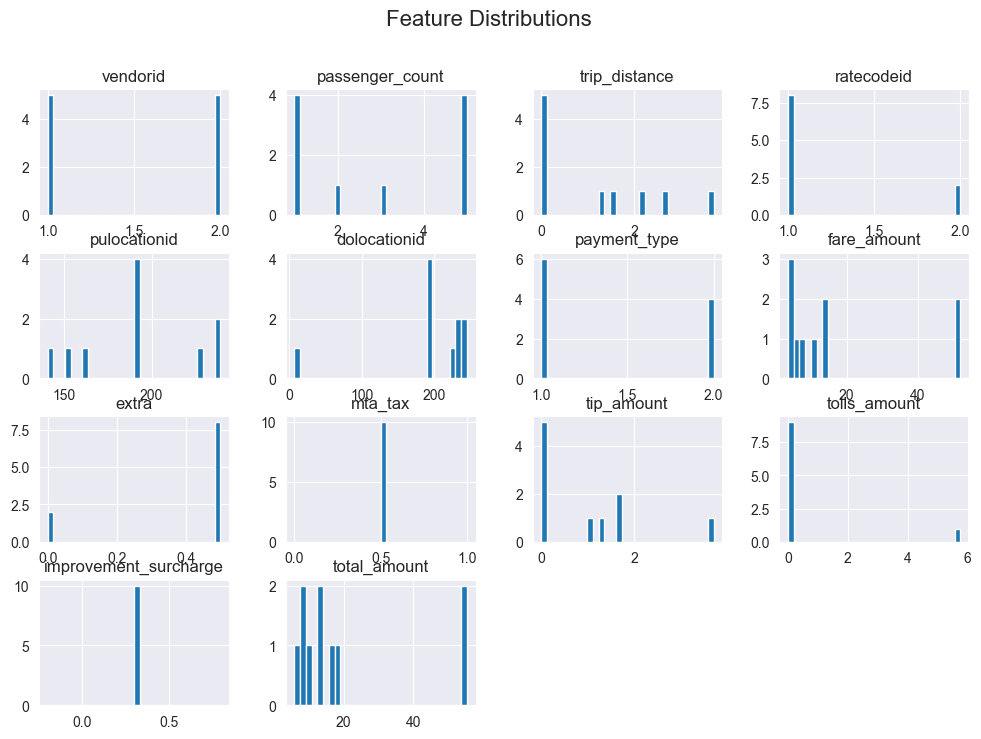

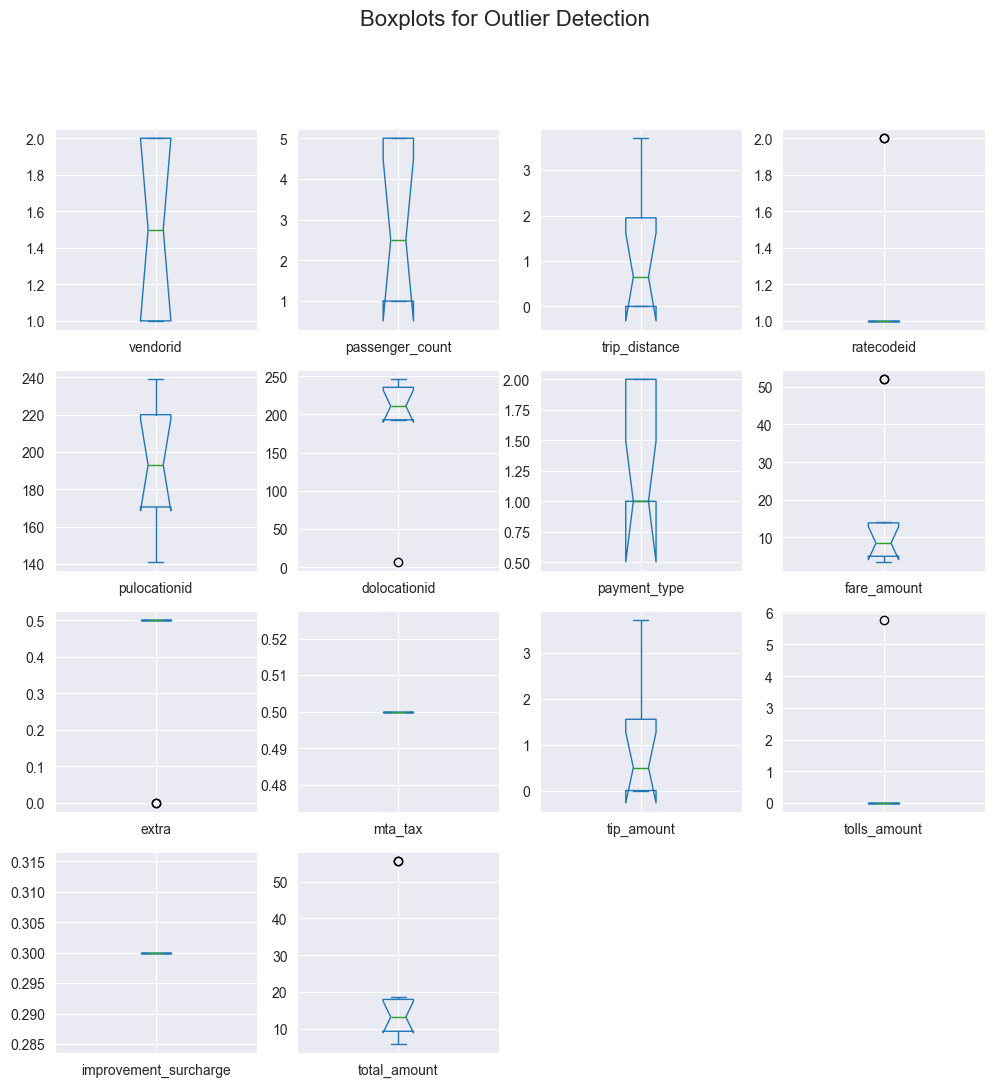

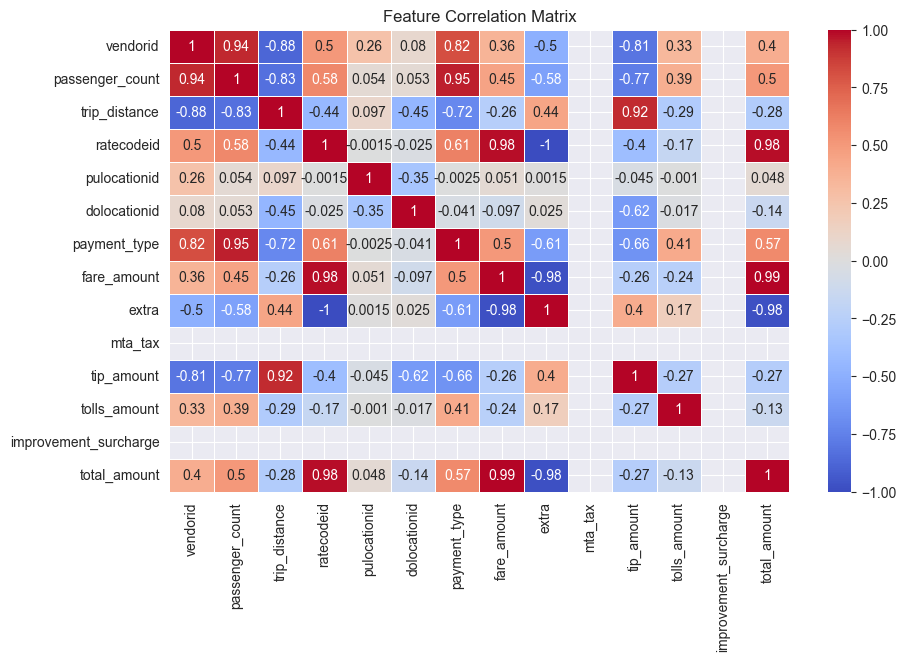

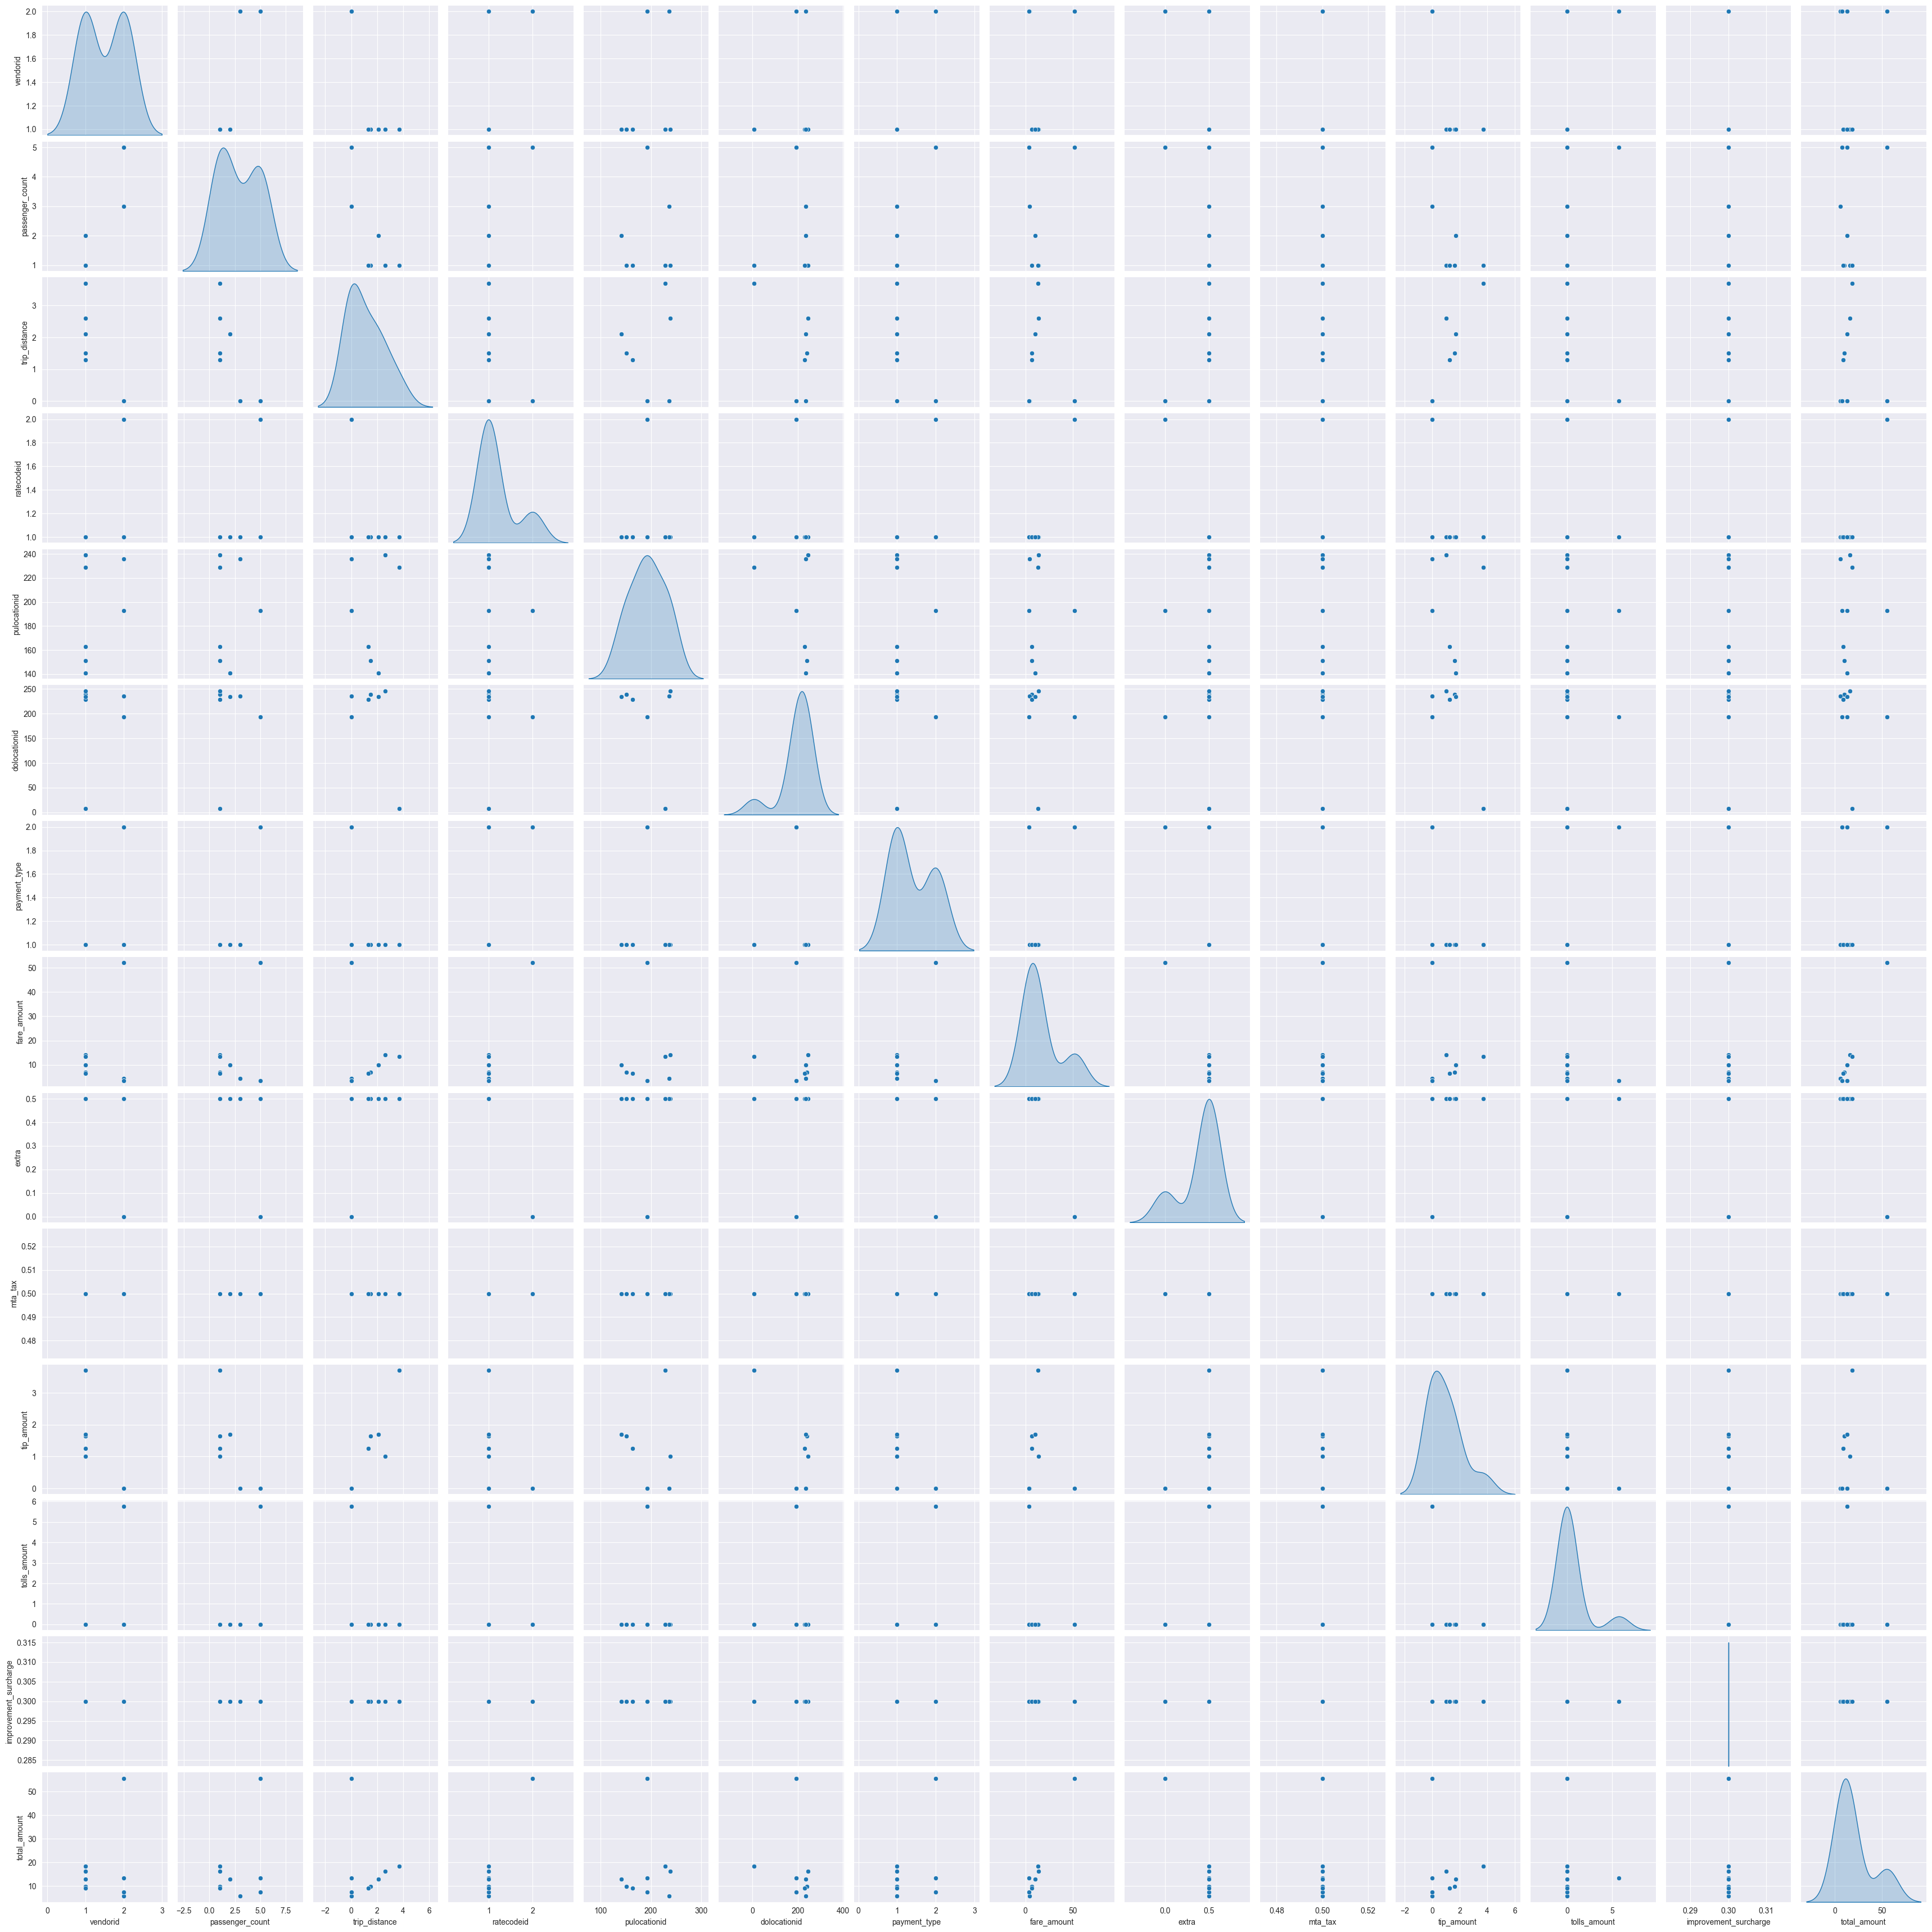

EDA completed successfully.


In [26]:
#Teste do EDA
sql_loader = KagglehubSQLiteLoader("dhruvildave/new-york-city-taxi-trips-2019", "\\2019\\2019-01.sqlite")
df = sql_loader.get_table_dataframe_nrows("tripdata", 10)
eda = EDA(df)
eda.run_eda()

In [ ]:
class DataVisualization:
    """
    A class responsible for data visualization.

    Attributes:
        data_analizer (DataAnalizer): An object of the DataAnalizer class containing the dataset.

    Methods:
        perform_visualization(): Performs data visualization.
    """

    def __init__(self, data_analizer):
        """
        Initializes the DataVisualization class with a DataAnalizer object.
        """
        self.data_analizer = data_analizer

    def perform_visualization(self):
        """
        Performs data visualization.
        """
        print("Data Visualization Plots:")
        print("-------------------------")

        # Pairplot
        print("\nPairplot:")
        self.plot_pairplot()

        # Boxplot
        print("\nBoxplot:")
        self.plot_boxplot()

        # Ridgeplot
        print("\nRidgeplot:")
        self.plot_ridgeplot()


    def plot_pairplot(self):
        """
        Plots pairplot for all features.
        """
        sns.pairplot(self.data_analizer.data_train, diag_kind='kde')
        plt.title("Pairplot of Features")
        plt.show()

    def plot_boxplot(self):
        """
        Plots boxplot for all features.
        """
        # Create a single figure and axis for all boxplots
        fig, ax = plt.subplots(figsize=(15, 8))
        
        # Plot boxplots for each feature
        sns.boxplot(data=self.data_analizer.data_train, ax=ax)
        ax.set_title("Boxplot of all Features")
        ax.set_xlabel("Feature")
        ax.set_ylabel("Value")
        ax.set_xticks(range(len(self.data_analizer.data_train.columns)))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  
        
        plt.tight_layout()
        plt.show()


    def plot_ridgeplot(self):
        """
        Plots overlapping densities (ridge plot) for all features.
        """
        
        # Create a single figure and axis for all boxplots
        fig, axes = plt.subplots(len(self.data_analizer.data_train.columns), 1, figsize=(10, 8), sharex=True)
        
        # Generate a gradient of darker colors for the plots
        num_plots = len(self.data_analizer.data_train.columns)
        cmap = plt.get_cmap('Blues')
        colors = [cmap(1 - i / (num_plots + 1)) for i in range(1, num_plots + 1)]
        
        # Plot overlapping densities for each numerical feature
        for i, (feature, color) in enumerate(zip(self.data_analizer.data_train.columns, colors)):
            sns.kdeplot(data=self.data_analizer.data_train[feature], ax=axes[i], color=color, fill=True, linewidth=2)
            axes[i].set_ylabel(feature, rotation=0, labelpad=40)  # Rotate y-axis label
            axes[i].yaxis.set_label_coords(-0.1, 0.5)  # Adjust label position
            axes[i].spines['top'].set_visible(False)
            
            # Remove box structure around the plots
            axes[i].spines['right'].set_visible(False)
            axes[i].spines['left'].set_visible(False)
            axes[i].spines['bottom'].set_visible(False)
        
        # Adjust plot aesthetics
        axes[-1].set_xlabel("Value")

        plt.tight_layout()
        plt.show()
    

In [39]:
#Feature Analysis
class FeatureAnalysis:

    def __init__(self, data_analizer, target_column):

        self.data_analizer = data_analizer
        self.target_column = target_column
        self.numerical_features = self.data_analizer.select_dtypes(include=['int64', 'float64']).columns.tolist()
        self.categorical_features = self.data_analizer.select_dtypes(include=['object']).columns.tolist()
        if self.target_column in self.numerical_features:
            self.numerical_features.remove(self.target_column)
        if self.target_column in self.categorical_features:
            self.categorical_features.remove(self.target_column)

    def feature_importance(self):
        """Computes and plots feature importance using a Random Forest model."""
        X = self.data_analizer.drop(columns=[self.target_column])
        y = self.data_analizer[self.target_column]

        # Encode categorical features
        if self.categorical_features:
            X[self.categorical_features] = X[self.categorical_features].apply(LabelEncoder().fit_transform)

        # Use RandomForestRegressor if target is continuous
        if y.dtype in ["int64", "float64"]:
            model = RandomForestRegressor(n_estimators=100, random_state=42)
        else:
            model = RandomForestClassifier(n_estimators=100, random_state=42)

        model.fit(X, y)

        # Plot feature importances
        feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
        feature_importance.plot(kind="bar", figsize=(12, 6), title="Feature Importance (Random Forest)")
        plt.show()

    def pca_analysis(self):

        X = self.data_analizer.drop(columns=[self.target_column])

        # Encode categorical features
        if self.categorical_features:
            X[self.categorical_features] = X[self.categorical_features].apply(LabelEncoder().fit_transform)

        # Scale the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Apply PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)

        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=self.data_analizer[self.target_column], cmap="viridis", alpha=0.5)
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.title("PCA Projection")
        plt.colorbar()
        plt.show()


    def run_all(self):
        self.feature_importance()
        self.pca_analysis()
        print("Feature Analysis completed successfully.")


#Feature Generator

Dataset downloaded Successfully 
Dataset saved on:  C:\Users\bruno\.cache\kagglehub\datasets\dhruvildave\new-york-city-taxi-trips-2019\versions\4


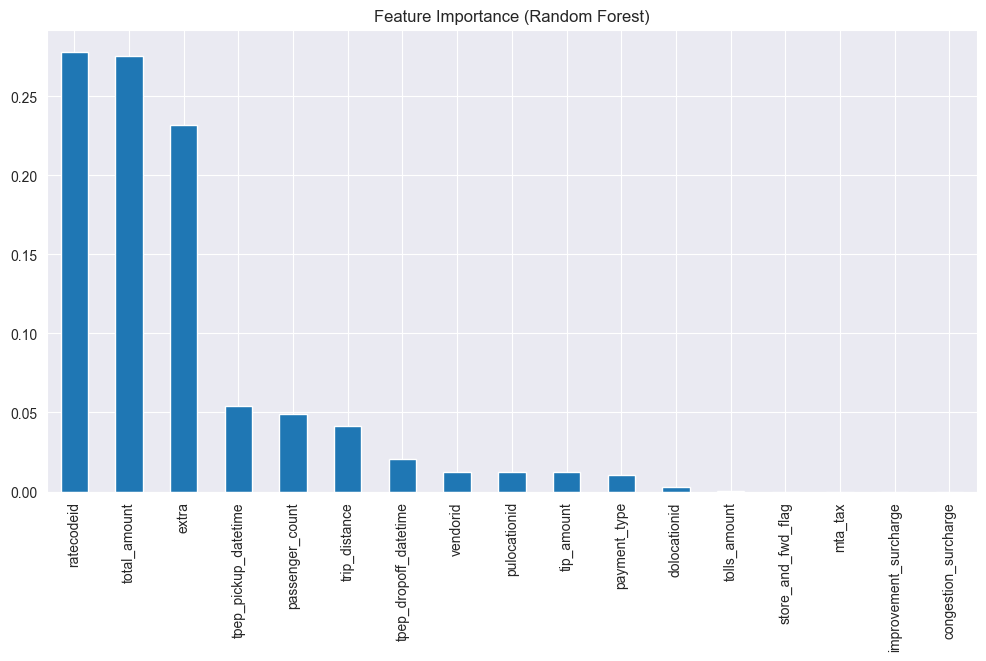

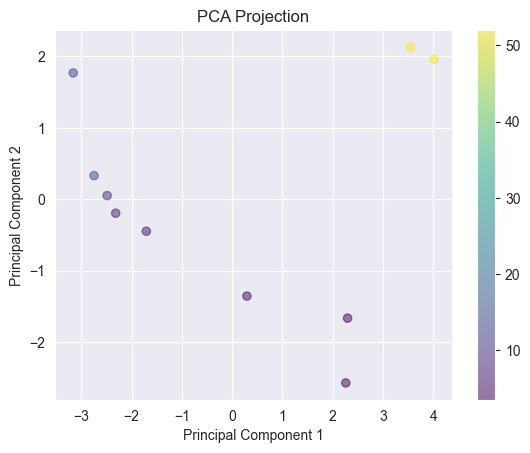

Feature Analysis completed successfully.


In [40]:
#Teste feature analysis
sql_loader = KagglehubSQLiteLoader("dhruvildave/new-york-city-taxi-trips-2019", "\\2019\\2019-01.sqlite")
df = sql_loader.get_table_dataframe_nrows("tripdata", 10)

analysis = FeatureAnalysis(df, target_column="fare_amount")
analysis.run_all()


# Statistical Analysis


In [ ]:
# Hypothesis Testing